In [24]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [2]:
df = pd.read_csv('data/Chicago_Merged.csv')
df = df.dropna()

/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Police Districts,Police Beats,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,0,10778514.0,HZ544820,2016-12-08 17:23:00,079XX S MAY ST,0820,THEFT,$500 AND UNDER,APARTMENT,False,...,20.0,230.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
1,1,11411914.0,JB390837,2018-08-12 22:00:00,013XX W 76TH ST,0560,ASSAULT,SIMPLE,APARTMENT,False,...,20.0,230.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
2,2,11510038.0,JB519570,2018-11-17 14:49:00,079XX S BISHOP ST,502P,OTHER OFFENSE,FALSE/STOLEN/ALTERED TRP,STREET,False,...,20.0,230.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
3,3,11495832.0,JB500163,2018-11-02 08:20:00,083XX S HALSTED ST,0484,BATTERY,PRO EMP HANDS NO/MIN INJURY,STREET,False,...,20.0,236.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
4,4,11501552.0,JB508324,2018-11-08 11:00:00,087XX S RACINE AVE,0810,THEFT,OVER $500,SIDEWALK,False,...,9.0,244.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0


### Crime Definitions:
 * **THEFT**: Steal something which belongs to someone else.
 * **BATTERY**: Cause physical harm to another person.
 * **CRIMINAL**: Destroying or damaging property.
 * **ASSAULT**: Threaten physical harm to another person.
 * **DECEPTIVE PRACTICE**: Attempt to deceive or defraud a person or business. 
 * **BURGLARY**: Breaking into someone's house with the intent of stealing.
 * **ROBBERY**: Stealing from someone with threats of violence (e.g. mugging).

In [3]:
df['Primary Type'].value_counts()

THEFT                                5627
BATTERY                              4567
CRIMINAL DAMAGE                      2609
ASSAULT                              1839
OTHER OFFENSE                        1562
DECEPTIVE PRACTICE                   1460
NARCOTICS                            1380
BURGLARY                             1096
MOTOR VEHICLE THEFT                  1015
ROBBERY                               969
CRIMINAL TRESPASS                     607
WEAPONS VIOLATION                     412
OFFENSE INVOLVING CHILDREN            195
PUBLIC PEACE VIOLATION                167
CRIM SEXUAL ASSAULT                   145
INTERFERENCE WITH PUBLIC OFFICER      117
SEX OFFENSE                           105
PROSTITUTION                           75
HOMICIDE                               43
ARSON                                  28
LIQUOR LAW VIOLATION                   21
GAMBLING                               20
KIDNAPPING                             20
STALKING                          

### Violent Crimes
* **BATTERY**
* **ASSAULT**
* **ROBBERY**
* **CRIMINAL SEXUAL ASSAULT**
* **KIDNAPPING**
* **HOMICIDE**
* **ARSON**

In [3]:
violent_crime = df[df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]
nonviolent_crime = df[~df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]

**The following function  helps us to determine the location of crime(including residential and non residential areas) and based on which we can analyse that in which location crime occurs frequently.**

In [8]:
def crime_locations(data, description):
    names = data.value_counts().keys().tolist()
    counts = data.value_counts().tolist()
    total = len(data)
    print(description)
    for i in range(5):
        percentage = (counts[i] / total) * 100
        print('{}: {}%'.format(names[i], int(round(percentage, 0))))
    print()

In [9]:
print('Top 5 locations of crime by percentage of crime which occured there')
crime_locations(df['Location Description'], 'All Crime')
crime_locations(violent_crime['Location Description'], 'Violent Crime')
crime_locations(nonviolent_crime['Location Description'], 'Nonviolent Crime')

Top 5 locations of crime by percentage of crime which occured there
All Crime
STREET: 23%
RESIDENCE: 16%
APARTMENT: 13%
SIDEWALK: 9%
OTHER: 4%

Violent Crime
APARTMENT: 20%
STREET: 17%
RESIDENCE: 16%
SIDEWALK: 15%
ALLEY: 3%

Nonviolent Crime
STREET: 26%
RESIDENCE: 16%
APARTMENT: 10%
SIDEWALK: 6%
OTHER: 5%



### INFERENCES:
**VIOLENT CRIME**: As seen in the above result, the percentage of violent crime is highest in the apartment which is 20%. The main reason could be that apartments might be more approachable for a criminal to break in and perform theft, sexual assault,etc.

**NON VIOLENT CRIME**: Crime such as kidnapping or battery are most commonly seen on streets (26%). The reason behind this is that most criminals may tend to kidnap people on some isolated streets.

In [10]:
df['Location Description'].value_counts()

STREET                                             5588
RESIDENCE                                          3858
APARTMENT                                          3142
SIDEWALK                                           2088
OTHER                                               932
PARKING LOT/GARAGE(NON.RESID.)                      716
SMALL RETAIL STORE                                  590
RESTAURANT                                          584
RESIDENTIAL YARD (FRONT/BACK)                       463
ALLEY                                               454
VEHICLE NON-COMMERCIAL                              440
RESIDENCE PORCH/HALLWAY                             436
DEPARTMENT STORE                                    408
RESIDENCE-GARAGE                                    399
SCHOOL, PUBLIC, BUILDING                            336
GAS STATION                                         331
GROCERY FOOD STORE                                  267
PARK PROPERTY                                   

**The following function  helps us to determine the percentage of arrest that took place due to violent and non violent crime.**

In [11]:
def arrest_percent(data, description):
    counts = data.value_counts().tolist()
    total = counts[0] + counts[1]
    false_percent = (counts[0] / total) * 100
    true_percent = (counts[1] / total) * 100
    print('{}\nNo arrest made: {}%\nArrest made: {}%\n'.format(description, int(round(false_percent, 0)), int(round(true_percent, 0))))

In [12]:
print('Crime arrest statistics\n')
arrest_percent(df['Arrest'], 'All Crime')
arrest_percent(violent_crime['Arrest'], 'Violent Crime')
arrest_percent(nonviolent_crime['Arrest'], 'Nonviolent Crime')

Crime arrest statistics

All Crime
No arrest made: 79%
Arrest made: 21%

Violent Crime
No arrest made: 81%
Arrest made: 19%

Nonviolent Crime
No arrest made: 78%
Arrest made: 22%



### INFERENCES:
A very small percentage of arrest in all the three categories can be noticed above. Though all the values for arrest rates are low but rate for non violent crime is higher than violent crime. 
Although, the police and government should be strict in arresting criminals for all types of crimes but looking at a low arrest rate of violent crime is non satisfactory. This may be due to ignorance of so many crimes occuring,lack of security, higher rate of crimes which cannot be handled by the police.



**The following function  helps us to determine the percentage of crime distribution in top five community areas(Austin,Near North Side,Loop,Near West Side, North Lawndale).**

In [14]:
def distribution(data, description):
    names = data.value_counts().keys().tolist()
    counts = data.value_counts().tolist()
    total = len(data)
    print(description)
    for i in range(5):
        print('{}: {}'.format(names[i], counts[i]))
    print()

In [15]:
print('Top 5 community areas for crime\n')
distribution(df['COMMUNITY AREA NAME'], 'All Crime')
distribution(violent_crime['COMMUNITY AREA NAME'], 'Violent Crime')
distribution(nonviolent_crime['COMMUNITY AREA NAME'], 'Nonviolent Crime')

Top 5 community areas for crime

All Crime
Austin: 1409
Near North Side: 1020
Loop: 907
Near West Side: 804
North Lawndale: 791

Violent Crime
Austin: 543
South Shore: 327
North Lawndale: 267
Auburn Gresham: 258
Humboldt park: 253

Nonviolent Crime
Austin: 866
Near North Side: 806
Loop: 758
Near West Side: 602
West Town: 545



### INFERENCES:
Maximum number of crimes occur in Austin followed by Near North Side, Loop, Near West Side, North Lawndale. This may be due to the absence of police stations, isolated areas, unemployment, poverty which in some cases may lead to attempt in crime like robbery, theft, assault and other crimes. 

## DATA PRE-PROCESSING




***One-hot Encoding*** : One hot encoding is a process of converting categorical variables into a form that is provided to machine learning algorithm to do a easier job. 
In this project, we are using one-hot encoder to convert following features:
* *Location Description*: The describes about location of crime.
* *Community Area* : Name of the community are where crime occurred.
* *Primary Type* : The type of crime committed.

In [4]:
oh_enc = OneHotEncoder(sparse=False)
location_description_enc = oh_enc.fit_transform(df['Location Description'].values.reshape(-1, 1))
print(location_description_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
oh_enc = OneHotEncoder(sparse=False)
community_area_enc = oh_enc.fit_transform(df['COMMUNITY AREA NAME'].values.reshape(-1, 1))
print(community_area_enc[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


In [6]:
oh_enc = OneHotEncoder(sparse=False)
crime_type_enc = oh_enc.fit_transform(df['Primary Type'].values.reshape(-1, 1))
print(crime_type_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0.]


***Ordinal Encoding***- This uses a single column to represent classes. Here, ordinal encoding is a string ( True or False) which states  whether the police have made an arrest for this crime. We will convert this feature using an original encoder so that it can be used in a machine learning model.

In [7]:
ord_enc = OrdinalEncoder()
arrest_ord_enc = ord_enc.fit_transform(df['Arrest'].values.reshape(-1, 1))

In [8]:
ord_enc = OrdinalEncoder()
domestic_ord_enc = ord_enc.fit_transform(df['Domestic'].values.reshape(-1, 1))

***Bucketing*** - Bucketing means putting in different categories. A new feature 'income' is being created from the 'per capita income' where 'high', 'medium' and 'low' are identified as buckets. 
* *An inbuilt library from sklearn- "KBinsDiscretizer" is being used.*

In [9]:
def bin_edges(d, title):
    print(title, 'ranges of each bin:')
    for i in range(1, len(d)):
        print('Bin {}: {} to {}'.format(i, d[i - 1], d[i]))
    print('')

In [10]:
disc = KBinsDiscretizer(n_bins=3, encode='ordinal')
bucket_income = disc.fit_transform(df['PER CAPITA INCOME '].values.reshape(-1, 1))
bin_edges(disc.bin_edges_[0], 'Bucket income')
df['bucket_income'] = bucket_income
print('Distribution of values in bins:')
print(df['bucket_income'].value_counts())

Bucket income ranges of each bin:
Bin 1: 8201.0 to 15957.0
Bin 2: 15957.0 to 24336.0
Bin 3: 24336.0 to 88669.0

Distribution of values in bins:
1.0    8266
2.0    8213
0.0    7648
Name: bucket_income, dtype: int64


In [11]:
disc = KBinsDiscretizer(n_bins=5, encode='onehot-dense')
bucket_latitude = disc.fit_transform(df['Latitude'].values.reshape(-1, 1))
bin_edges(disc.bin_edges_[0], 'Latitude')
disc = KBinsDiscretizer(n_bins=5, encode='onehot-dense')
bucket_longitude = disc.fit_transform(df['Longitude'].values.reshape(-1, 1))
bin_edges(disc.bin_edges_[0], 'Longitude')

Latitude ranges of each bin:
Bin 1: 41.647924640999996 to 41.759324223600004
Bin 2: 41.759324223600004 to 41.81373832039999
Bin 3: 41.81373832039999 to 41.881512491
Bin 4: 41.881512491 to 41.918329869
Bin 5: 41.918329869 to 42.022536147

Longitude ranges of each bin:
Bin 1: -87.914869723 to -87.7230788748
Bin 2: -87.7230788748 to -87.6838677316
Bin 3: -87.6838677316 to -87.64979390760001
Bin 4: -87.64979390760001 to -87.62378751860001
Bin 5: -87.62378751860001 to -87.525749601



## CREATING SYNTHETIC FEATURES
### Feature Engineering: 
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Synthetic features is a form of feature engineering. We create folloeing features:
* Time of day
* Weekend
* Violent crime

In [13]:
def time_of_day(x):
    time = x[-8:]
    hour = int(time[:2])
    if hour <= 6:
        return 'early morning'
    if hour > 6 and hour < 18:
        return 'day'
    return 'night'

df['hour'] = df['Date'].map(lambda x: time_of_day(x))
df['hour'].value_counts()

day              12452
night             7510
early morning     4165
Name: hour, dtype: int64

In [14]:
oh_enc = OneHotEncoder(sparse=False)
hour_enc = oh_enc.fit_transform(df['hour'].values.reshape(-1, 1))

In [15]:
def is_weekend(x):
    dt = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    day = dt.weekday()
    if day < 5:
        return 0
    return 1

In [16]:
df['is_weekend'] = df['Date'].map(lambda x: is_weekend(x))
df['is_weekend'].value_counts()

0    17247
1     6880
Name: is_weekend, dtype: int64

In [17]:
weekend_enc = df['is_weekend'].values.reshape(-1, 1)

In [18]:
def is_violent(x):
    if x in ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON']:
        return 1
    return 0

In [19]:
df['is_violent'] = df['Primary Type'].map(lambda x: is_violent(x))
df['is_violent'].value_counts()

0    16516
1     7611
Name: is_violent, dtype: int64

In [20]:
violent_enc = df['is_violent'].values.reshape(-1, 1)

## Predicting Where Crimes Occur
This is framed as a three-class classification problem, where the labels are: low wealth, moderate wealth, and high wealth areas. This feature was created by binning the income per capita of the community area in which the crime occured.

### Creating Training and Test Data
The training data will be used to train the model, while the test data for evaluation. A seperate test set simulates how the model generalises to new data and helps us find models that are overfitting to training data.
The processed data is combined into 'X (features) array' and 'y (labels) array'. This will then be split into train and test sets by the sklearn train_test_split function.

In [104]:
X = np.concatenate((arrest_ord_enc, hour_enc, weekend_enc, violent_enc, domestic_ord_enc, location_description_enc, crime_type_enc, bucket_latitude, bucket_longitude), axis=1)
y = bucket_income
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), random_state=1)

### Logistic Regression (baseline)
The simplist type of model, logisitc regression, will be compared to the other techniques to find the best performing model.

In [50]:
def plot_confusion_matrix(title, actual, predicted, classes, figsize = (10,7)):
    matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(
        matrix, index=classes, columns=classes, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    title = title + ' Confusion Matrix'
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

Train Accuracy:  0.7129593810444874
Test Accuracy:  0.718501326259947


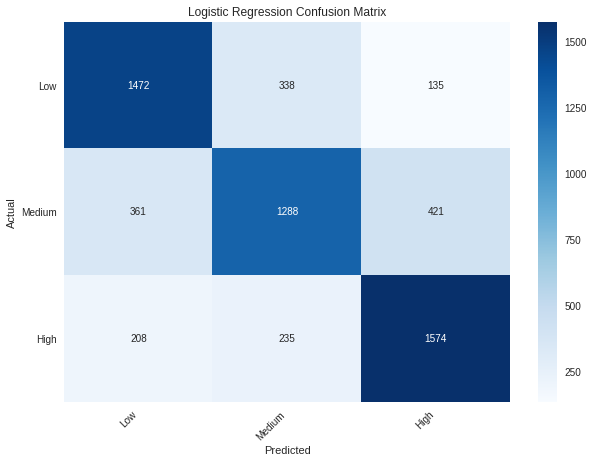

In [105]:
model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, y_train)
print('Train Accuracy: ', model.score(X_train, y_train))
print('Test Accuracy: ', model.score(X_test, y_test))
model_pred = model.predict(X_test)
model_classes = ['Low', 'Medium', 'High']
plot_confusion_matrix('Logistic Regression', y_test, model_pred, model_classes)

#### Baseline Results
An almost 72% accuracy isn't too bad for a three-class classification problem, as random chance is only 33% accuracy. The model is definitely learning useful information from the data to make predictions. The train and test accuracies indicate that the model isn't overfitting.

### Support Vector Machine Model (SVM)

Train Accuracy:  0.6699640784747167
Test Accuracy:  0.6856763925729443


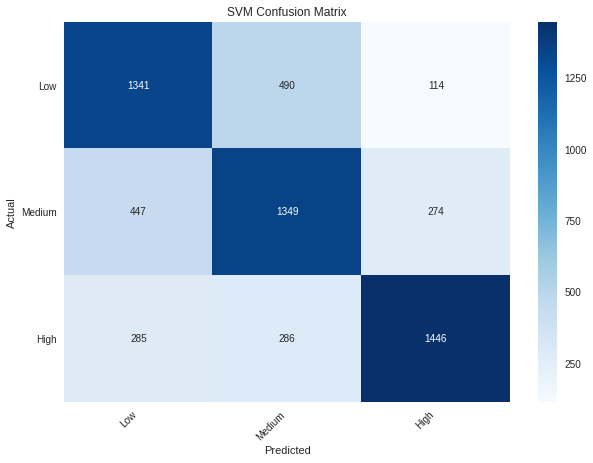

In [106]:
svm_model = SVC(gamma='auto')
svm_model.fit(X_train, y_train)
print('Train Accuracy: ', svm_model.score(X_train, y_train))
print('Test Accuracy: ', svm_model.score(X_test, y_test))
model_pred = svm_model.predict(X_test)
plot_confusion_matrix('SVM', y_test, model_pred, model_classes)

#### SVM Results
Was the slowest model to train and had the weakest performance of any model. It did correctly predict medium income with a better accuracy than the baseline, but was worse at predicting crime that would occur in low and high income areas. The train and test accuracies indicate that the model isn't overfitting. Surprisingly, the test accuracy is marginally higher than the train.

### K-Nearest Neighbors Model

Train Accuracy:  0.7866814037026802
Test Accuracy:  0.7050729442970822


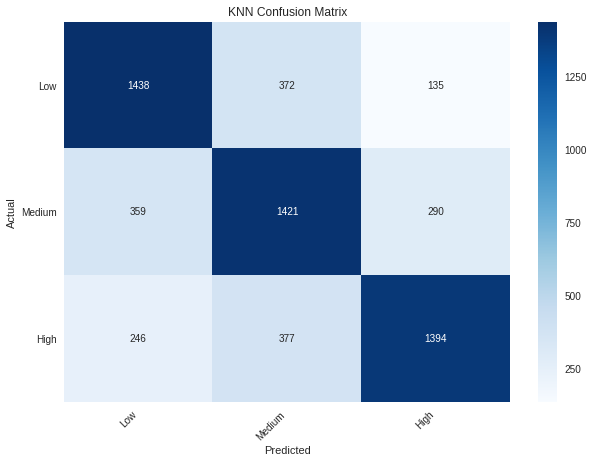

In [107]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
print('Train Accuracy: ', knn_model.score(X_train, y_train))
print('Test Accuracy: ', knn_model.score(X_test, y_test))
model_pred = knn_model.predict(X_test)
plot_confusion_matrix('KNN', y_test, model_pred, model_classes)

#### KNN Results
The KNN performed better than both the baseline and SVM at predicting crime in moderately-weathly areas, but performed worse than the baseline at about low and high income predictions. Overall, the accuracy of the KNN was slightly worse than the baseline. The train and test accuracies indicate that the model is overfitting as the test accuracy is about 8% lower than the train accuracy.

### Neural Network Model

Train Accuracy:  0.7750759878419453
Test Accuracy:  0.7662466843501327


/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


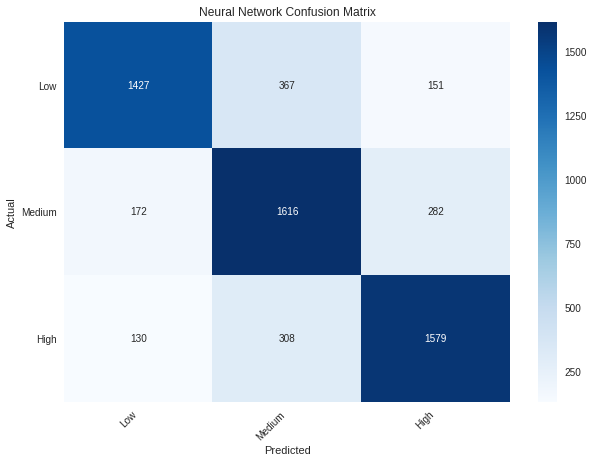

In [108]:
nn_model = MLPClassifier(random_state=0, max_iter=10)
nn_model.fit(X_train, y_train)
print('Train Accuracy: ', nn_model.score(X_train, y_train))
print('Test Accuracy: ', nn_model.score(X_test, y_test))
model_pred = nn_model.predict(X_test)
plot_confusion_matrix('Neural Network', y_test, model_pred, model_classes)

#### Neural Network Results
This model performed the best of all, with an almost 5% accuracy improvement over the baseline model. It made up that ground with a high level of accuracy for moderate-income areas, but performed to a comparable level to the baseline on low and high income predictions. The train and test accuracies indicate that the model isn't overfitting.

#### Neural Network Iteration Testing

In [68]:
train_scores = []
test_scores = []
iterations = []

for i in range(10, 51, 10):
    mlp = MLPClassifier(random_state=0, max_iter=i)
    mlp.fit(X_train, y_train)
    train_scores.append(mlp.score(X_train, y_train))
    test_scores.append(mlp.score(X_test, y_test))
    iterations.append(i)

/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: 

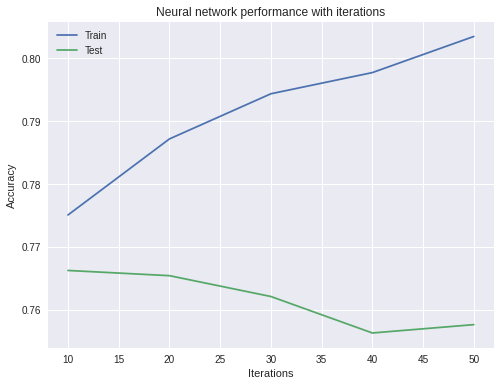

In [69]:
plt.figure(figsize=(8, 6))    
plt.plot(iterations, train_scores, label='Train')
plt.plot(iterations, test_scores, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Neural network performance with iterations')
leg = plt.legend()
plt.grid(True)
plt.show()

**Iteration Observations**  
Despite the complaints of the model not reaching convergence, the best result for test accuracy is actually the lowest number of iterations. Above 10 iterations the model starts overfitting the training data.

#### Neural Network Solver Testing

In [102]:
train_scores = []
test_scores = []
solvers = ['lbfgs','sgd', 'adam']
for i in solvers:
    mlp = MLPClassifier(solver=i, random_state=0, max_iter=10)
    mlp.fit(X_train, y_train)
    train_scores.append(mlp.score(X_train, y_train))
    test_scores.append(mlp.score(X_test, y_test))

/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


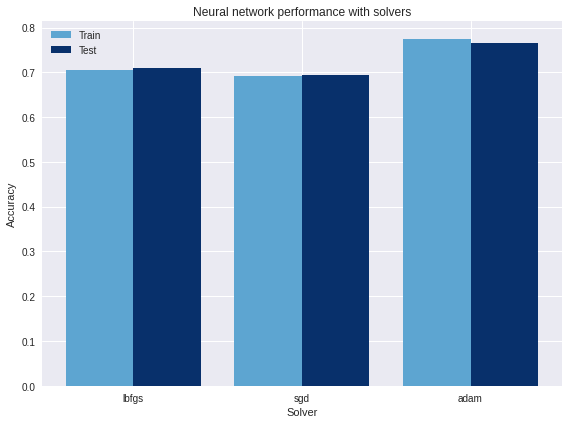

In [103]:
n_groups = 3
index = np.arange(n_groups)
plt.figure(figsize=(8, 6))
bar_width = 0.4
plt.bar(index, train_scores, bar_width, color='#5da5d1', label='Train')
plt.bar(index + bar_width, test_scores, bar_width, color='#08306b', label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Solver')
plt.title('Neural network performance with solvers')
leg = plt.legend()
plt.xticks(index + bar_width/2, solvers)
plt.grid(True)
plt.tight_layout()
plt.show()

**Solver observations**  
The adam solver, which is the default for the MLPClassifier, has a noticible improvement in accuracy over the others for this problem.

## Predicting violent crime
This is a binary classification problem, where the labels are: nonviolent and violent. The features include: the time of day, whether an arrest occured, a description of the location, and what community area it took place in. Since this is now a binary classification problem, we can now easily use Receiver Operating Characteristic (ROC) Area Under Curve (AUC) as an additional metric to accuracy.

In [109]:
X = np.concatenate((arrest_ord_enc, hour_enc, weekend_enc, domestic_ord_enc, location_description_enc, bucket_latitude, bucket_longitude, community_area_enc, bucket_income), axis=1)
y = df['is_violent'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
encoder = OneHotEncoder()
encoder.fit([[0], [1]])
y_test_proba = encoder.transform(y_test.reshape(-1, 1)).toarray()

/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Logistic Regression (baseline)

Train Accuracy:  0.7767339043934789
Test Accuracy:  0.7664124668435013
ROC AUC:  0.7682436802513741


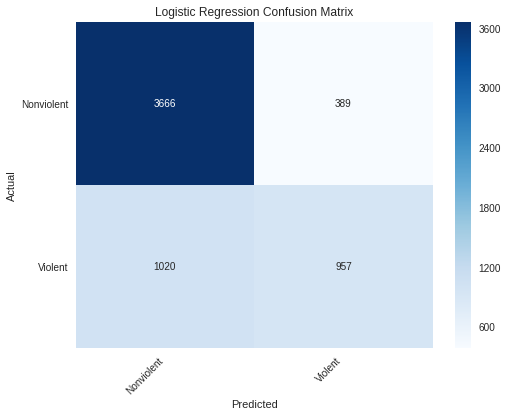

In [110]:
model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, y_train)
print('Train Accuracy: ', model.score(X_train, y_train))
print('Test Accuracy: ', model.score(X_test, y_test))
model_pred = model.predict(X_test)
probabilities = model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
model_classes = ['Nonviolent', 'Violent']
plot_confusion_matrix('Logistic Regression', y_test, model_pred, model_classes, figsize = (8,6))

#### Baseline Results
A 76% accuracy isn't incredible for a binary classification task, but the model is learning something from the data to perform 26% above random chance. Interestingly, the accuracy for nonviolent crime is significantly higher than for violent crime. The train and test accuracies indicate that the model isn't overfitting.

### Support Vector Machine Model

Train Accuracy:  0.7548494059132357
Test Accuracy:  0.7420424403183024
ROC AUC:  0.7539838849606479


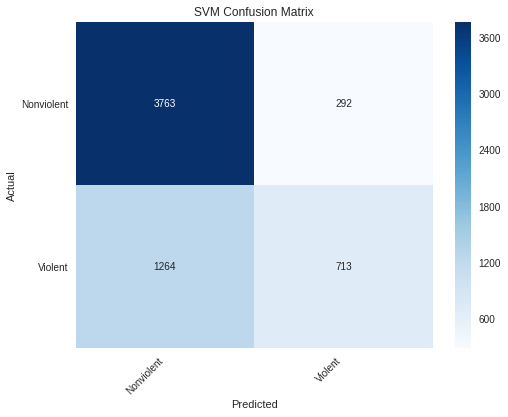

In [111]:
svm_model = SVC(gamma='auto', probability=True)
svm_model.fit(X_train, y_train)
print('Train Accuracy: ', svm_model.score(X_train, y_train))
print('Test Accuracy: ', svm_model.score(X_test, y_test))
model_pred = svm_model.predict(X_test)
probabilities = svm_model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('SVM', y_test, model_pred, model_classes, figsize = (8,6))

#### SVM Results
Accuracy and ROC AUC are both slightly lower than the baseline model, but interestingly it has the lowest number of false positives of any of the models (nonviolent crimes predicted incorrectly as violent). Unfortunately, it didn't do well at predicting violent crime: far more violent crimes were incorrectly predited to be nonviolent. The train and test accuracies indicate that the model isn't overfitting.

### K-Nearest Neighbours Model

Train Accuracy:  0.7977341807129041
Test Accuracy:  0.7122015915119363
ROC AUC:  0.6977744056651491


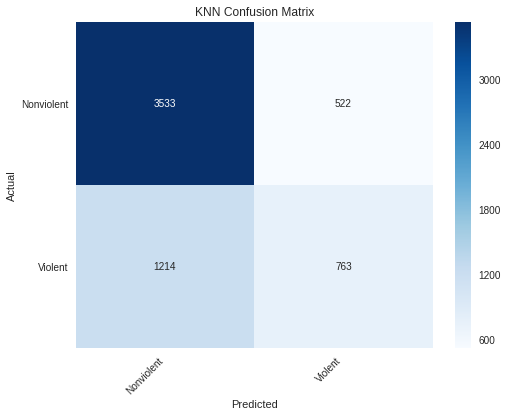

In [112]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
print('Train Accuracy: ', knn_model.score(X_train, y_train))
print('Test Accuracy: ', knn_model.score(X_test, y_test))
model_pred = knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('KNN', y_test, model_pred, model_classes, figsize = (8,6))

#### KNN Results
The KNN model was the weakest performing out of all the models. It was inferior in every aspect to the baseline model. The train and test accuracies indicate that the model is overfitting as the test accuracy is about 8% lower than the train accuracy.

#### Trying different numbers of neighbors
Perhaps the default setting of 5 neighbors wasn't the best for this problem?

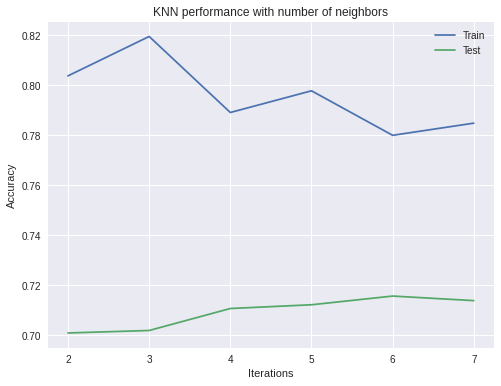

In [100]:
train_scores = []
test_scores = []
iterations = []

for i in range(2, 8):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))
    iterations.append(i)

plt.figure(figsize=(8, 6))    
plt.plot(iterations, train_scores, label='Train')
plt.plot(iterations, test_scores, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('KNN performance with number of neighbors')
leg = plt.legend()
plt.grid(True)
plt.show()

#### Finding the best value of K
The default K of 5 seems perfectly reasonable, but it appears the results were slightly better at 6.

### Naive Bayes Classifier Model

Train Accuracy:  0.7467808786957724
Test Accuracy:  0.7327586206896551
ROC AUC:  0.7363280999060091


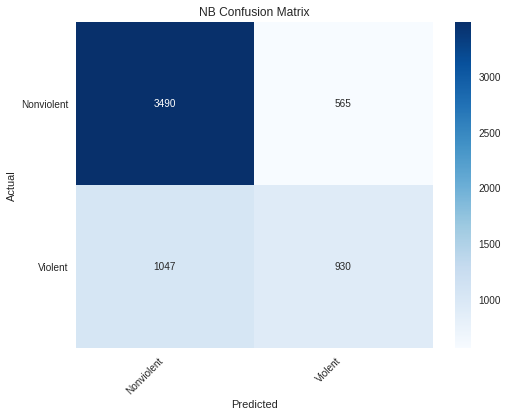

In [113]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
probabilities = nb_model.predict_proba(X_test)
model_pred = nb_model.predict(X_test)
print('Train Accuracy: ', nb_model.score(X_train, y_train))
print('Test Accuracy: ', nb_model.score(X_test, y_test))
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('NB', y_test, model_pred, model_classes, figsize = (8,6))

#### Naive Bayes Results
The Naive Bayes model has solid, but unremarkable performance. It performed better than the KNN model, but slightly worse than the baseline in all cases. The train and test accuracies indicate that the model isn't overfitting.

### Neural Network Model

Train Accuracy:  0.7929814865985079
Test Accuracy:  0.7795092838196287
ROC AUC:  0.7682436802513741


/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


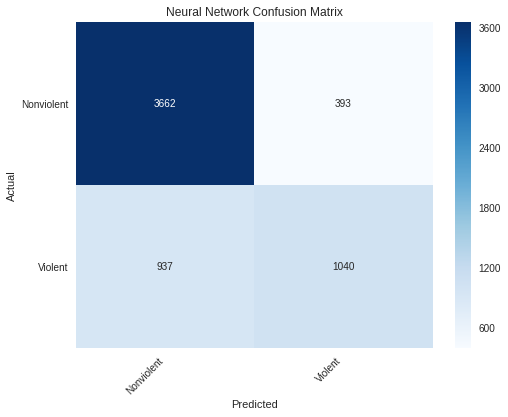

In [114]:
nn_model = MLPClassifier(random_state=0, max_iter=10)
nn_model.fit(X_train, y_train)
print('Train Accuracy: ', nn_model.score(X_train, y_train))
print('Test Accuracy: ', nn_model.score(X_test, y_test))
model_pred = nn_model.predict(X_test)
probabilities = model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('Neural Network', y_test, model_pred, model_classes, figsize = (8,6))

#### Neural Network Results
This model performed the best in every metric, and was the only model which was able to correctly predict more violent crimes than it got wrong. The train and test accuracies indicate that the model isn't overfitting.

#### Neural Network Iteration Testing
The goal is to find the best number of iterations using the test set accuracy as the metric.

/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jarred/dev/comp257/portfolio-2019-jarredr/env/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: 

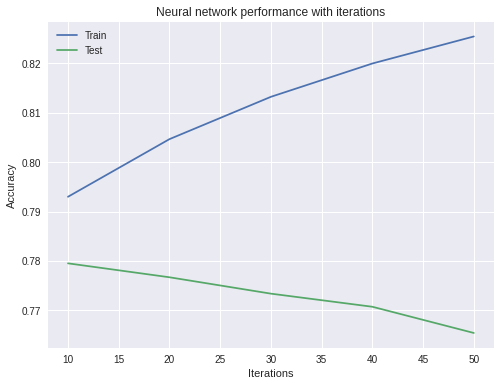

In [93]:
train_scores = []
test_scores = []
iterations = []

for i in range(10, 51, 10):
    mlp = MLPClassifier(random_state=0, max_iter=i)
    mlp.fit(X_train, y_train)
    train_scores.append(mlp.score(X_train, y_train))
    test_scores.append(mlp.score(X_test, y_test))
    iterations.append(i)

plt.figure(figsize=(8, 6))    
plt.plot(iterations, train_scores, label='Train')
plt.plot(iterations, test_scores, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Neural network performance with iterations')
leg = plt.legend()
plt.grid(True)
plt.show()

#### Iteration Testing
The neural network starts overfitting immediately after 10 iterations, so keeping the iterations low is ideal in this case.